In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import collections

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import plotly.express as px
import scipy.stats as st
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from xgboost import XGBRegressor

In [ ]:
### Create user-defined functions ###

def breed_type(breed):
  if "Mix" in breed or "/" in breed:
    return "Mixed"
  else:
    return "Purebred"

def color_num(color):
  if "/" in color:
    return 2
  if "Tricolor" in color:
    return 3
  else:
    return 1

def age_in_weeks(age):
  age_str = str(age)
  age_split = age_str.split()
  if "year" in age_str or "years" in age_str:
    return int(age_split[0]) * 52
  if "month" in age_str or "month" in age_str:
    return int(age_split[0]) * 4
  if "week" in age_str or "weeks" in age_str:
    return int(age_split[0])

def is_neutered(sex_upon_outcome):
  if "Neutered" in str(sex_upon_outcome):
    return 1
  else:
    return 0

def is_male(sex_upon_outcome):
  if "Male" in str(sex_upon_outcome):
    return 1
  else:
    return 0

def age_group(age_week):
  weeks_in_year = 52.14
  approx_lifespan_weeks = weeks_in_year * 10
  low_thresh = weeks_in_year * 2
  upper_thresh = weeks_in_year * 5

  if age_week <= low_thresh:
    return "young"
  if (age_week > low_thresh) & (age_week <= upper_thresh):
    return "middle aged"
  if age_week > upper_thresh:
    return "late life"
  else:
    return "unknown"

def age_group_int(age_week):
  weeks_in_year = 52.14
  approx_lifespan_weeks = weeks_in_year * 10
  low_thresh = weeks_in_year * 2
  upper_thresh = weeks_in_year * 5

  if age_week <= low_thresh:
    return 0
  if (age_week > low_thresh) & (age_week <= upper_thresh):
    return 1
  if age_week > upper_thresh:
    return 2
  else:
    return -1

def is_dog(AnimalType):
  if AnimalType == 'Cat':
    return 0
  if AnimalType == 'Dog':
    return 1

def engineer_features(df):
  df["breed_type"] = df['Breed'].map(lambda Breed: breed_type(Breed))
  df["color_num"] = df['Color'].map(lambda Color: color_num(Color))
  df["age_in_weeks"] = df['AgeuponOutcome'].map(lambda age: age_in_weeks(age))
  df["is_neutered"] = df['SexuponOutcome'].map(lambda sex_upon_outcome: is_neutered(sex_upon_outcome))
  df["is_male"] = df['SexuponOutcome'].map(lambda sex_upon_outcome: is_male(sex_upon_outcome))
  df['age_group'] = df['age_in_weeks'].map(lambda age_week: age_group(age_week))
  df['age_group_int'] = df['age_in_weeks'].map(lambda age_week: age_group_int(age_week))
  df['DateTime'] = pd.to_datetime(df['DateTime'])
  df['Day_of_Week'] = df['DateTime'].dt.day_name()
  df['is_dog'] = df['AnimalType'].map(lambda animal: is_dog(animal))
  return df

def fill_na_columns(df):
  # Get NA columns
  na_cols = df.columns[df.isna().any()].tolist()

  # Fill NA Cols
  for col in na_cols:
    if df[col].dtype == object:
      df[col] = df[col].fillna("Unknown")
    else:
      df[col] = df[col].fillna(-1)
  return df


  def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

In [ ]:
# Read in both data sets
df_train= pd.read_csv("train.csv")
df_test= pd.read_csv("test.csv")

# Update train and test sets to include new features
df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

df_train = fill_na_columns(df_train)
df_test = fill_na_columns(df_test)

In [ ]:
#combined_dfs=pd.concat([df_train, df_test], ignore_index=True)

# EDA

In [ ]:
#Exploratory Analysis on Train Data
df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AnimalID        26729 non-null  object        
 1   Name            26729 non-null  object        
 2   DateTime        26729 non-null  datetime64[ns]
 3   OutcomeType     26729 non-null  object        
 4   OutcomeSubtype  26729 non-null  object        
 5   AnimalType      26729 non-null  object        
 6   SexuponOutcome  26729 non-null  object        
 7   AgeuponOutcome  26729 non-null  object        
 8   Breed           26729 non-null  object        
 9   Color           26729 non-null  object        
 10  breed_type      26729 non-null  object        
 11  color_num       26729 non-null  int64         
 12  age_in_weeks    26729 non-null  float64       
 13  is_neutered     26729 non-null  int64         
 14  is_male         26729 non-null  int64         
 15  ag

,color_num,age_in_weeks,is_neutered,is_male,age_group_int,is_dog
count,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000,26729.000000
mean,1.577201,112.670844,0.365857,0.497737,0.371058,0.583449
std,0.548014,154.471547,0.481679,0.500004,0.711165,0.492996
min,1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000
25%,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,52.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,156.000000,1.000000,1.000000,1.000000,1.000000
max,3.000000,1040.000000,1.000000,1.000000,2.000000,1.000000


Takeaways: More dogs come in to the shelter than cats, the most common outcome is adoption

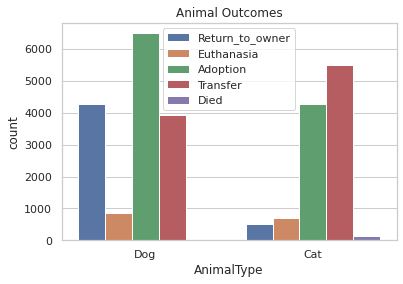

In [ ]:
#Big picture -- adoption rates or adoption count for all outcomes grouped by animal
sns.set_theme(style="whitegrid")
sns.countplot(data=df_train, x="AnimalType", hue="OutcomeType").set(title='Animal Outcomes')
plt.legend(loc='upper center')
#Takeaways: More dogs come in to the shelter than cats, the most common age when the animals leave the shelter is 1 year (makes sense as younger animals are more desired for most people)

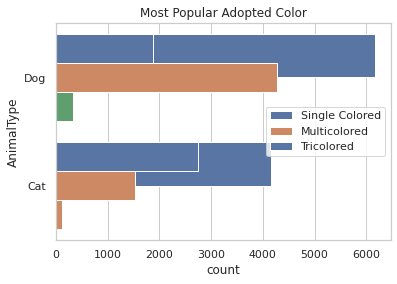

In [ ]:
#What is the most common breed and colors to be adopted by dogs and cats?
#Data Cleaning: So many different types of breeds len(df_train['Breed'].unique())== 1,380 different types, Grab top 5 and label the rest as 'Other
#Breed: Dogs

sns.set_theme(style="whitegrid")
sns.countplot(data=df_train[df_train['OutcomeType']=='Adoption'],y= "AnimalType", hue="breed_type").set(title='Most Popular Adopted Breeds')
plt.legend(loc='best')

sns.set_theme(style="whitegrid")
sns.countplot(data=df_train[df_train['OutcomeType']=='Adoption'],y= "AnimalType", hue="color_num").set(title='Most Popular Adopted Color')
plt.legend(loc='best',labels=['Single Colored','Multicolored',"Tricolored"])
plt.savefig('AnimalColors.png',bbox_inches='tight',transparent=True)


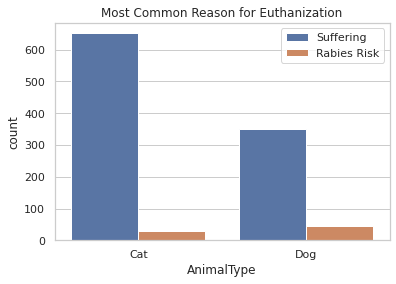

In [ ]:
# Are there particular animals that display rabies risk? suffering?
df=df_train[(df_train['OutcomeSubtype']=='Suffering')|(df_train['OutcomeSubtype']=='Rabies Risk')]
sns.set_theme(style="whitegrid")
sns.countplot(data=df,x= "AnimalType", hue="OutcomeSubtype").set(title='Most Common Reason for Euthanization')
plt.legend(loc='best')
plt.savefig('AnimalEuth.png',bbox_inches='tight',transparent=True)
# young, middle aged, late life


In [ ]:
cat_age= df_train[df_train['AnimalType']=='Cat']
#cat_age
cat_age = cat_age[cat_age['age_in_weeks']<=700]
cat_age.describe()

,color_num,age_in_weeks,is_neutered,is_male,age_group_int,is_dog
count,11057.000000,11057.000000,11057.000000,11057.000000,11057.000000,11057.0
mean,1.352808,65.086190,0.274125,0.448223,0.174640,0.0
std,0.478055,120.145986,0.446092,0.497334,0.579417,0.0
min,1.000000,-1.000000,0.000000,0.000000,-1.000000,0.0
25%,1.000000,4.000000,0.000000,0.000000,0.000000,0.0
50%,1.000000,12.000000,0.000000,0.000000,0.000000,0.0
75%,2.000000,52.000000,1.000000,1.000000,0.000000,0.0
max,3.000000,676.000000,1.000000,1.000000,2.000000,0.0


Text(0, 0.5, 'count')

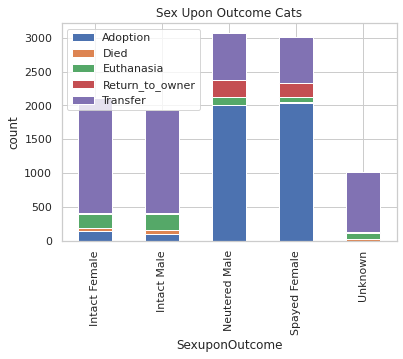

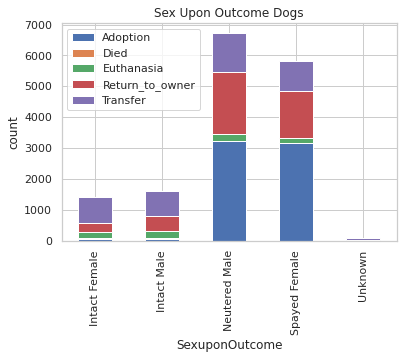

In [ ]:
#Are neuteured animals more likely to survive?
#Break up by cat and dog
#Cat
cat_sex= df_train[df_train['AnimalType']=='Cat'].groupby(by=['SexuponOutcome','OutcomeType']).count()
cat_sex.pivot_table(index = 'SexuponOutcome', columns = 'OutcomeType' , values = 'AnimalID').plot(kind = 'bar', stacked = True)\
.set(title='Sex Upon Outcome Cats')
plt.legend(loc='upper left')
plt.ylabel('count')
#fig = plt.figure(figsize=(9, 11))
#plt.savefig('test3.png',bbox_inches='tight')

#Dog
dog_sex= df_train[df_train['AnimalType']=='Dog'].groupby(by=['SexuponOutcome','OutcomeType']).count()
dog_sex.pivot_table(index = 'SexuponOutcome', columns = 'OutcomeType' , values = 'AnimalID').plot(kind = 'bar', stacked = True)\
.set(title='Sex Upon Outcome Dogs')
plt.legend(loc='upper left')
plt.ylabel('count')
#fig = plt.figure(figsize=(9, 11))
#plt.savefig('test3.png',bbox_inches='tight')

# Modelling

In [ ]:
# Drop unnecessary columns
train = df_train.copy()

select_cols = ['OutcomeType', 'color_num', 'age_in_weeks', 'is_neutered', 'is_male', 'age_group_int', 'is_dog']
train = train.loc[:, select_cols]


# Encode outcome using Label encoder
label_encoder = LabelEncoder()
train['OutcomeType'] = label_encoder.fit_transform(train['OutcomeType'])

# Split into x and y
X = train.drop(['OutcomeType'], axis = 1)
y = train['OutcomeType']

# Split into train and test sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.85)

# to numpy
x_train = x_train.to_numpy()

y_train = y_train.to_numpy()
x_valid = x_valid.to_numpy()
y_valid = y_valid.to_numpy()
del(X, y)

### Define Grid Search Parameters for Random Forest Model

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 500, num = 6)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4, 8, 12]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print("Random Grid:", random_grid)

Random Grid: {'n_estimators': [300, 340, 380, 420, 460, 500], 'max_features': ['sqrt'], 'max_depth': [2, 5, 9, 12, 16, 20, None], 'min_samples_split': [2, 4, 6], 'min_samples_leaf': [4, 8, 12], 'bootstrap': [True]}


### Perform Randomized Grid Search for Random Forest Classifier using 5-fold Cross-Validation

In [ ]:
# Define model
rf = RandomForestClassifier()

# Establish Randomized Grid Search CV
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 3, verbose=2, random_state=100, n_jobs = -1)

# Train the model on the training data
rf_random.fit(x_train, y_train)

joblib.dump(rf_random, "random_forest_grid_search.pkl")

Fitting 3 folds for each of 300 candidates, totalling 900 fits


['random_forest_grid_search.pkl']

### Define Grid Search Parameters for Extreme Gradient Boosting (XGBoost) Model  

In [ ]:
# n estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 3)]

# Number of trees in random forest
learning_rates = [x for x in np.linspace(start = 0.1, stop = 1, num = 3)]

# Number of trees in random forest
subsamples = [x for x in np.linspace(start = 0.1, stop = 1, num = 3)]

min_samples_split = [x for x in np.linspace(start = 0.05, stop = 1, num = 3)]

min_samples_leaf = [x for x in np.linspace(start = 0.05, stop = 1, num = 3)]

min_weight_fraction_leaf = [x for x in np.linspace(start = 0.01, stop = 0.5, num = 2)]

max_depth = [x for x in np.linspace(start = 0, stop = 50, num = 3)]

# Number of features to consider at every split
max_features = ['sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
grid_search_params = {
               'n_estimators': n_estimators,
               'learning_rate':learning_rates,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }

print("Grid Search Params:",grid_search_params)

Grid Search Params: {'n_estimators': [200, 350, 500], 'learning_rate': [0.1, 0.55, 1.0], 'max_features': ['sqrt'], 'max_depth': [10, 60, 110, None], 'min_samples_split': [0.05, 0.525, 1.0], 'min_samples_leaf': [0.05, 0.525, 1.0]}


### Perform Randomized Grid Search for XGBoost Classifier using 3-fold Cross-Validation

In [ ]:
gb = GradientBoostingClassifier()
# 50 splits used initially; retrying with 300
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = grid_search_params, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1).fit(x_train, y_train)

gb_random.fit(x_train, y_train)

joblib.dump(gb_random, "xgboost_grid_search.pkl")

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
588 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
285 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 596, in fit
    monitor,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 672, in _fit_stages
    X_csr,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 246, in _fit_stage
    tr

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
588 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
285 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 596, in fit
    monitor,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 672, in _fit_stages
    X_csr,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py", line 246, in _fit_stage
    tr

['xgboost_grid_search.pkl']

# Grid Search Plot

In [ ]:
random_forest_gs = joblib.load(r'random_forest_grid_search.pkl')
xgboost_gs = joblib.load('xgboost_grid_search.pkl')

In [ ]:
xgboost_gs.best_estimator_

GradientBoostingClassifier(learning_rate=0.55, max_depth=60,
                           max_features='sqrt', min_samples_leaf=0.05,
                           min_samples_split=0.525, n_estimators=350)

In [ ]:

random_forest_gs.best_estimator_

RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=12,
                       min_samples_split=4, n_estimators=380)

In [ ]:
svm_random.best_estimator_

SVC(decision_function_shape='ovo')

In [ ]:
cv_results = random_forest_gs.cv_results_
results = pd.DataFrame(cv_results)[['params', 'mean_test_score', 'rank_test_score', 'std_test_score']]
results.sort_values('rank_test_score')

,params,mean_test_score,rank_test_score,std_test_score
18,"{'n_estimators': 380, 'min_samples_split': 4, ...",0.595317,1,0.003978
87,"{'n_estimators': 380, 'min_samples_split': 4, ...",0.594656,2,0.003427
97,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.594568,3,0.003873
109,"{'n_estimators': 340, 'min_samples_split': 4, ...",0.594480,4,0.002650
156,"{'n_estimators': 340, 'min_samples_split': 6, ...",0.594436,5,0.003352
...,...,...,...,...
283,"{'n_estimators': 420, 'min_samples_split': 4, ...",0.519169,296,0.013123
207,"{'n_estimators': 340, 'min_samples_split': 4, ...",0.519125,297,0.000942
180,"{'n_estimators': 340, 'min_samples_split': 2, ...",0.517056,298,0.007968
260,"{'n_estimators': 380, 'min_samples_split': 4, ...",0.515164,299,0.008357


### Create Grid Search Plot


best parameters: {'n_estimators': 380, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
best score:      -0.59532 (+/-0.00398)
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 12,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 380,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
18,2.652604,0.026254,0.451665,0.008027,380,4,12,sqrt,5,True,"{'n_estimators': 380, 'min_samples_split': 4, ...",0.600687,0.594084,0.591179,0.595317,0.003978,1
87,2.625092,0.017564,0.441840,0.007189,380,4,8,sqrt,5,True,"{'n_estimators': 380, 'min_samples_split': 4, ...",0.599366,0.593292,0.591311,0.594656,0.003427,2
97,3.465050,0.029525,0.590610,0.012193,500,2,4,sqrt,5,True,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.600026,0.592236,0.591443,0.594568,0.003873,3
109,2.775573,0.030040,0.498914,0.009649,340,4,12,sqrt,9,True,"{'n_estimators': 340, 'min_samples_split': 4, ...",0.598178,0.592104,0.593160,0.594480,0.002650,4
156,2.394880,0.020543,0.393844,0.004513,340,6,8,sqrt,5,True,"{'n_estimators': 340, 'min_samples_split': 6, ...",0.598706,0.594084,0.590519,0.594436,0.003352,5
272,3.407513,0.017043,0.583428,0.007130,500,6,8,sqrt,5,True,"{'n_estimators': 500, 'min_samples_split': 6, ...",0.598310,0.594216,0.590519,0.594348,0.003182,6
262,3.109050,0.033714,0.546311,0.007245,380,2,12,sqrt,9,True,"{'n_estimators': 380, 'min_samples_split': 2, ...",0.598706,0.591443,0.592632,0.594260,0.003181,7
177,2.921728,0.005622,0.496077,0.008634,420,4,12,sqrt,5,True,"{'n_estimators': 420, 'min_samples_split': 4, ...",0.598046,0.593820,0.590783,0.594216,0.002978,8
32,3.464718,0.026219,0.602932,0.009390,420,6,12,sqrt,9,True,"{'n_estimators': 420, 'min_samples_split': 6, ...",0.598442,0.591179,0.593028,0.594216,0.003082,8
85,2.054876,0.013019,0.346286,0.003387,300,4,4,sqrt,5,True,"{'n_estimators': 300, 'min_samples_split': 4, ...",0.599894,0.594084,0.588538,0.594172,0.004637,10


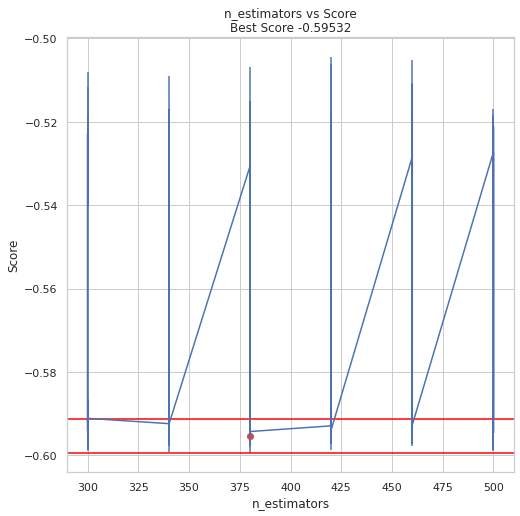

In [ ]:
GridSearch_table_plot(random_forest_gs, "n_estimators")

best parameters: {'n_estimators': 350, 'min_samples_split': 0.525, 'min_samples_leaf': 0.05, 'max_features': 'sqrt', 'max_depth': 60, 'learning_rate': 0.55}
best score:      -0.59629 (+/-0.00231)
{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.55,
 'loss': 'deviance',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.05,
 'min_samples_split': 0.525,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
134,20.435494,0.065482,0.268346,0.005987,350,0.525,0.05,sqrt,60,0.55,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.597782,0.593028,0.598046,0.596285,0.002306,1
234,29.328133,0.099293,0.377916,0.000463,500,0.525,0.05,sqrt,60,0.1,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.599234,0.590915,0.596197,0.595449,0.003437,2
93,29.056228,0.148399,0.385983,0.014607,500,0.525,0.05,sqrt,110,1.0,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.597517,0.592764,0.595141,0.595141,0.001941,3
23,25.697546,0.078910,0.527554,0.010800,350,0.05,0.05,sqrt,None,0.1,"{'n_estimators': 350, 'min_samples_split': 0.0...",0.597782,0.593556,0.593820,0.595053,0.001933,4
106,30.149791,0.672450,0.382272,0.005966,500,0.525,0.05,sqrt,10,0.55,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.596989,0.592896,0.595009,0.594965,0.001671,5
39,11.735642,0.065374,0.155855,0.000279,200,0.525,0.05,sqrt,110,0.55,"{'n_estimators': 200, 'min_samples_split': 0.5...",0.597517,0.591443,0.595801,0.594921,0.002557,6
184,20.505883,0.084314,0.266904,0.004269,350,0.525,0.05,sqrt,60,1.0,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.595405,0.594348,0.594877,0.594877,0.000431,7
292,14.633468,0.064154,0.301576,0.002558,200,0.05,0.05,sqrt,110,0.1,"{'n_estimators': 200, 'min_samples_split': 0.0...",0.598178,0.592236,0.594216,0.594877,0.002470,7
243,20.484341,0.147603,0.267054,0.003668,350,0.525,0.05,sqrt,None,1.0,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.597385,0.592236,0.594877,0.594833,0.002103,9
287,21.003903,0.662447,0.265614,0.002202,350,0.525,0.05,sqrt,110,0.55,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.595009,0.591971,0.597517,0.594833,0.002268,10


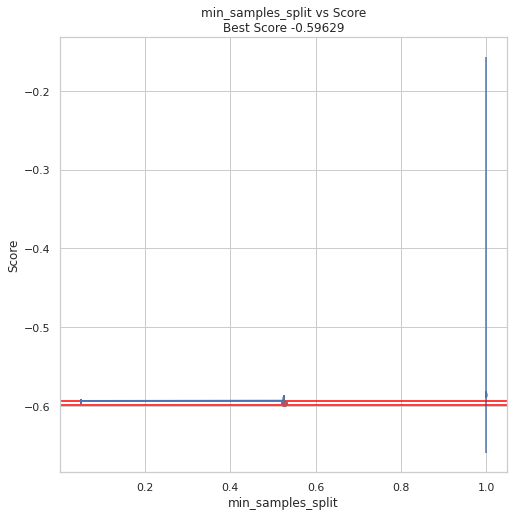

best parameters: {'n_estimators': 350, 'min_samples_split': 0.525, 'min_samples_leaf': 0.05, 'max_features': 'sqrt', 'max_depth': 60, 'learning_rate': 0.55}
best score:      -0.59629 (+/-0.00231)
{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.55,
 'loss': 'deviance',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.05,
 'min_samples_split': 0.525,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
134,20.435494,0.065482,0.268346,0.005987,350,0.525,0.05,sqrt,60,0.55,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.597782,0.593028,0.598046,0.596285,0.002306,1
234,29.328133,0.099293,0.377916,0.000463,500,0.525,0.05,sqrt,60,0.1,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.599234,0.590915,0.596197,0.595449,0.003437,2
93,29.056228,0.148399,0.385983,0.014607,500,0.525,0.05,sqrt,110,1.0,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.597517,0.592764,0.595141,0.595141,0.001941,3
23,25.697546,0.078910,0.527554,0.010800,350,0.05,0.05,sqrt,None,0.1,"{'n_estimators': 350, 'min_samples_split': 0.0...",0.597782,0.593556,0.593820,0.595053,0.001933,4
106,30.149791,0.672450,0.382272,0.005966,500,0.525,0.05,sqrt,10,0.55,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.596989,0.592896,0.595009,0.594965,0.001671,5
39,11.735642,0.065374,0.155855,0.000279,200,0.525,0.05,sqrt,110,0.55,"{'n_estimators': 200, 'min_samples_split': 0.5...",0.597517,0.591443,0.595801,0.594921,0.002557,6
184,20.505883,0.084314,0.266904,0.004269,350,0.525,0.05,sqrt,60,1.0,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.595405,0.594348,0.594877,0.594877,0.000431,7
292,14.633468,0.064154,0.301576,0.002558,200,0.05,0.05,sqrt,110,0.1,"{'n_estimators': 200, 'min_samples_split': 0.0...",0.598178,0.592236,0.594216,0.594877,0.002470,7
243,20.484341,0.147603,0.267054,0.003668,350,0.525,0.05,sqrt,None,1.0,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.597385,0.592236,0.594877,0.594833,0.002103,9
287,21.003903,0.662447,0.265614,0.002202,350,0.525,0.05,sqrt,110,0.55,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.595009,0.591971,0.597517,0.594833,0.002268,10


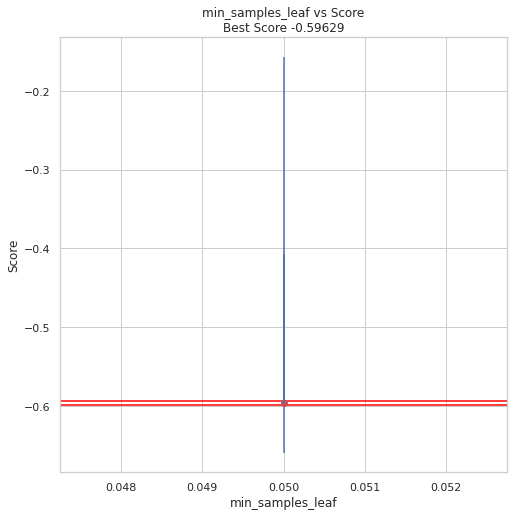

best parameters: {'n_estimators': 350, 'min_samples_split': 0.525, 'min_samples_leaf': 0.05, 'max_features': 'sqrt', 'max_depth': 60, 'learning_rate': 0.55}
best score:      -0.59629 (+/-0.00231)
{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.55,
 'loss': 'deviance',
 'max_depth': 60,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 0.05,
 'min_samples_split': 0.525,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
134,20.435494,0.065482,0.268346,0.005987,350,0.525,0.05,sqrt,60,0.55,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.597782,0.593028,0.598046,0.596285,0.002306,1
234,29.328133,0.099293,0.377916,0.000463,500,0.525,0.05,sqrt,60,0.1,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.599234,0.590915,0.596197,0.595449,0.003437,2
93,29.056228,0.148399,0.385983,0.014607,500,0.525,0.05,sqrt,110,1.0,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.597517,0.592764,0.595141,0.595141,0.001941,3
23,25.697546,0.078910,0.527554,0.010800,350,0.05,0.05,sqrt,None,0.1,"{'n_estimators': 350, 'min_samples_split': 0.0...",0.597782,0.593556,0.593820,0.595053,0.001933,4
106,30.149791,0.672450,0.382272,0.005966,500,0.525,0.05,sqrt,10,0.55,"{'n_estimators': 500, 'min_samples_split': 0.5...",0.596989,0.592896,0.595009,0.594965,0.001671,5
39,11.735642,0.065374,0.155855,0.000279,200,0.525,0.05,sqrt,110,0.55,"{'n_estimators': 200, 'min_samples_split': 0.5...",0.597517,0.591443,0.595801,0.594921,0.002557,6
184,20.505883,0.084314,0.266904,0.004269,350,0.525,0.05,sqrt,60,1.0,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.595405,0.594348,0.594877,0.594877,0.000431,7
292,14.633468,0.064154,0.301576,0.002558,200,0.05,0.05,sqrt,110,0.1,"{'n_estimators': 200, 'min_samples_split': 0.0...",0.598178,0.592236,0.594216,0.594877,0.002470,7
243,20.484341,0.147603,0.267054,0.003668,350,0.525,0.05,sqrt,None,1.0,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.597385,0.592236,0.594877,0.594833,0.002103,9
287,21.003903,0.662447,0.265614,0.002202,350,0.525,0.05,sqrt,110,0.55,"{'n_estimators': 350, 'min_samples_split': 0.5...",0.595009,0.591971,0.597517,0.594833,0.002268,10


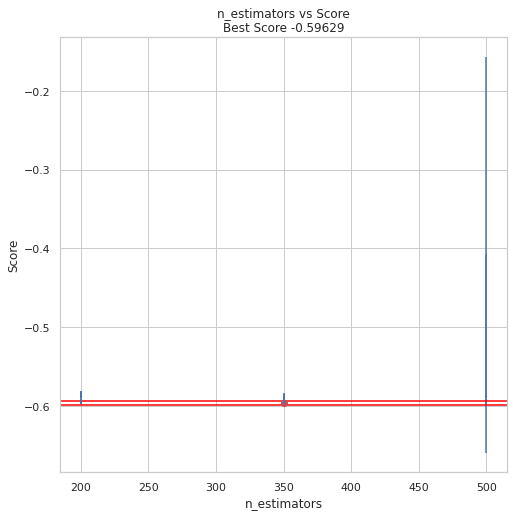

In [ ]:
cv_results = xgboost_gs.cv_results_
results = pd.DataFrame(cv_results)[['params', 'mean_test_score', 'rank_test_score', 'std_test_score']]
results.sort_values('rank_test_score')

GridSearch_table_plot(xgboost_gs, "min_samples_split")
GridSearch_table_plot(xgboost_gs, "min_samples_leaf")
GridSearch_table_plot(xgboost_gs, "n_estimators")

### SVC for classification

In [ ]:
### Train the top-performing models & compare
from sklearn import svm
decision_function_shapes = ['ovo', 'ovr']
grid_search_params = {'decision_function_shape': decision_function_shapes}
clf = svm.SVC()

# can show the number ofo support vectors for each class.
svm_random = RandomizedSearchCV(estimator = clf, param_distributions = grid_search_params, n_iter = 30, cv = 3, verbose = 2, random_state = 42, n_jobs = -1).fit(x_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning:

The total space of parameters 2 is smaller than n_iter=30. Running 2 iterations. For exhaustive searches, use GridSearchCV.



In [ ]:
### Use 5-fold CV on Top Models
gb_scores = cross_val_score(gb_random.best_estimator_, x_train, y_train, cv = 10)
rf_scores = cross_val_score(rf_random.best_estimator_, x_train, y_train, cv = 10)
svm_scores = cross_val_score(svm_random.best_estimator_, x_train, y_train, cv = 10)

In [ ]:
# Model names and performance
model_names = ['XGBoost', 'Random Forest', "SVM"]
mean_scores = [gb_scores.mean(), rf_scores.mean(), svm_scores.mean()]
mean_scores = [round(i, 3) for i in mean_scores]
std_scores = [gb_scores.std(), rf_scores.std(), svm_scores.std()]
train_results_dict = {
                    'Model': model_names,
                    'Mean Score': mean_scores,
                    'Std Score': std_scores
                }
train_results = pd.DataFrame(train_results_dict)
train_results

# Save train results
joblib.dump(train_results, "train_results.pkl")

NameError: ignored

### Plot Training Results


In [ ]:
train_results = joblib.load('train_results.pkl')
fig = px.bar(train_results, x = 'Model', y = 'Mean Score', error_y = 'Std Score', color = 'Model', title = "Model Mean & St. Dev. of Accuracy on Train Set using 10-fold Cross-Validation",\
       labels = {'Mean Score': 'Accuracy'}, text_auto=True, width=800, height=400)

fig.update_layout(yaxis_range=[0, 1])

### Fit best model on all training data & evaluate

In [ ]:
xgb = xgboost_gs.best_estimator_
xgb.fit(x_train, y_train)

model_preds = xgb.predict(x_valid)

# Predictor using max class
d = collections.Counter(y_train)
d = dict(d)
print("Result of train outcomes:", d)

max_val = 0
naive_preds = np.repeat(max_val, len(y_valid))

model_score = round(accuracy_score(y_valid, model_preds), 3)
naive_score = round(accuracy_score(y_valid, naive_preds), 3)
print(model_score, naive_score)

In [ ]:
# Plot
final_models = ['XGBoost', "Naive"]
scores = [model_score, naive_score]
res = pd.DataFrame({'Model':final_models, "Accuracy":scores})


fig = px.bar(res, x = 'Model', y = 'Accuracy', color = 'Model', title = "XGBoost VS Naive Model Performance on Test Set",\
       labels = {'Mean Score': 'Accuracy'}, text_auto=True, width=800, height=400)

fig.update_layout(yaxis_range=[0, 1])

In [ ]:
?ConfusionMatrixDisplay.plot
#?confusion_matrix

AttributeError: ignored

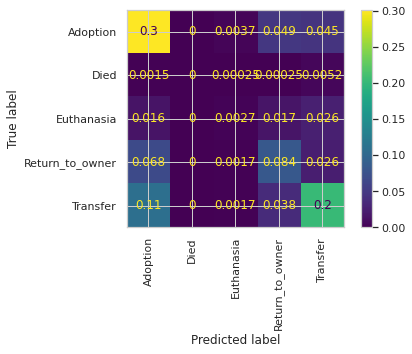

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot confusion matrix of final model



cm = confusion_matrix(y_valid, model_preds, normalize = 'all')
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = label_encoder.classes_,
                              #labels = label_encoder.classes_
                              #xticks_rotation = 'vertical'
                              )

plt = disp.plot(xticks_rotation = 'vertical')
plt.grid(False)

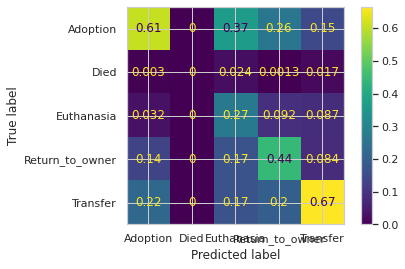

In [ ]:
cm = confusion_matrix(y_valid, model_preds, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = label_encoder.classes_,
                              #labels = label_encoder.classes_
                              #xticks_rotation = 'vertical'
                              )

disp.plot()
